# Designing an A/B test and analyzing the results

The company is developing an entertainment app with an "infinite" feed feature, like short video apps. The app has two monetization models: the first is a monthly paid subscription that allows users to watch the feed without ads, and the second is showing ads to users who have not yet subscribed.

The recommendation engine team has created a new recommendation algorithm that they believe will show more interesting content to each user. As an analyst, you are asked to help design the parameters of an A/B test that will test this hypothesis and analyze its results.

## Data Description

You will be working with three datasets:

- `sessions_project_history.csv` — contains historical session data for the period from **2025-08-15** to **2025-09-23**.  
  File path: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — contains data for the **first day** of the A/B test: **2025-10-14**.  
  File path: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — contains data for the **entire test period**: from **2025-10-14** to **2025-11-02**.  
  File path: `/datasets/sessions_project_test.csv`.

All three datasets share nearly identical structure and column meanings. The only difference is the observation period.

### Dataset Columns (`sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`):

- `user_id` — user identifier  
- `session_id` — session identifier in the app  
- `session_date` — date of the session  
- `session_start_ts` — timestamp of session start  
- `install_date` — date the app was installed  
- `session_number` — ordinal number of the session for the user  
- `registration_flag` — whether the user is registered  
- `page_counter` — number of pages viewed during the session  
- `region` — user region  
- `device` — user device type  
- `test_group` — A/B test group  
  *(Note: the historical dataset does not include this column.)*

---

## Objective

- Calculate test parameters  
- Validate the integrity of the experiment  
- Analyze the test results

### 1. Working with historical data (EDA)

#### 1.1. Loading historical data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil

!pip install matplotlib-venn -q
from matplotlib_venn import venn2

from scipy import stats

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Unload sessions_project_history.csv data into a variable
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

display(sessions_history.head(5))
display(sessions_history.info())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


None

#### 1.2. Getting to Know the Data
- For each unique user `user_id`, calculate the number of unique sessions `session_id`.

- Display all the data from the `sessions_history` table for one user with the largest number of sessions.

- Study the table for one user to better understand the logic behind the formation of each data column.

In [3]:
# Group by user_id and count the number of unique session_id
session_counts = sessions_history.groupby('user_id')['session_id'].nunique()

# Find the user with the maximum number of sessions
top_user_id = session_counts.idxmax()

# Output all lines according to it
top_user_data = sessions_history[sessions_history['user_id'] == top_user_id]
display(top_user_data)


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Registration Number Analysis
One of the most important product metrics is the number of registered users. Let's examine how the number of registrations in the application has changed over the course of its existence.

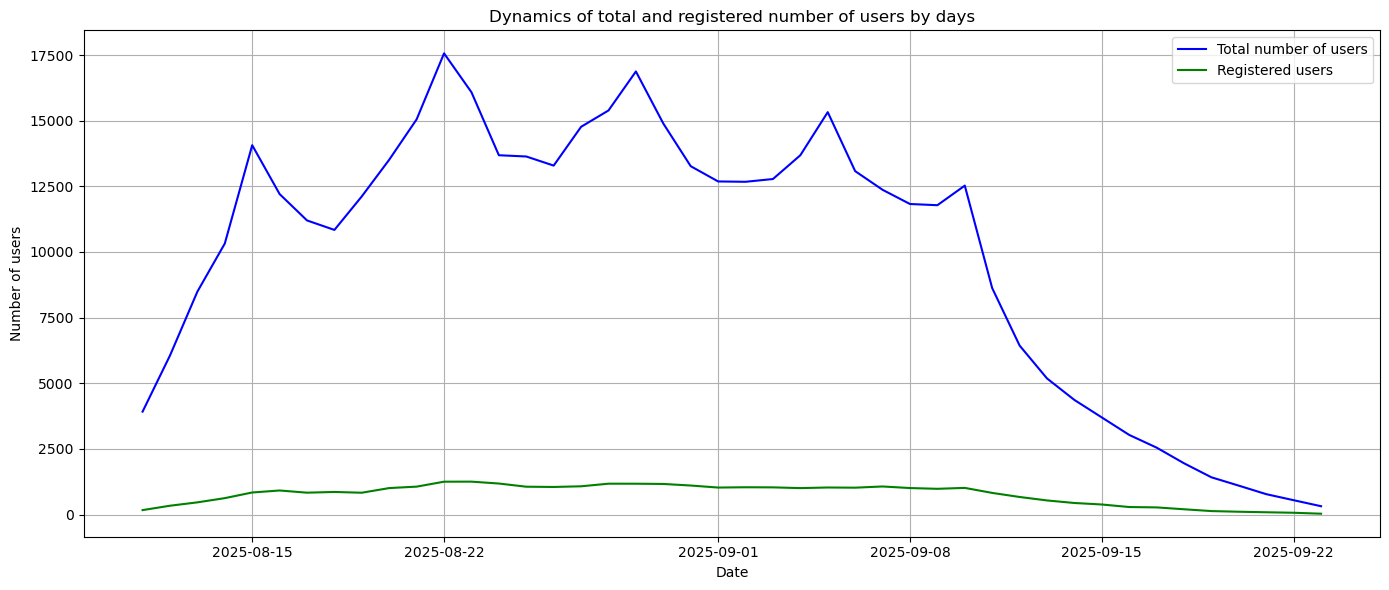

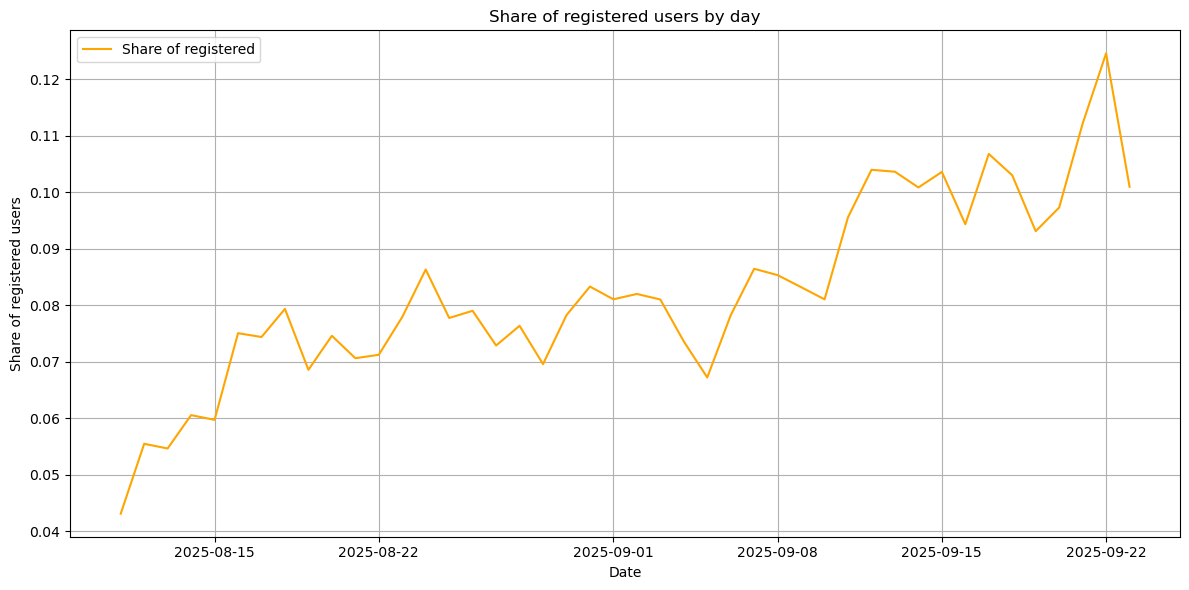

In [4]:
# Convert the date
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

# Aggregation
daily_stats = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', lambda x: x.eq(1).sum())
).reset_index()

# Share of registered# Share of registered
daily_stats['registered_share'] = daily_stats['registered_users'] / daily_stats['total_users']

# Visualization of total and registered on one axis
plt.figure(figsize=(14, 6))
plt.plot(daily_stats['session_date'], daily_stats['total_users'], label='Total number of users', color='blue')
plt.plot(daily_stats['session_date'], daily_stats['registered_users'], label='Registered users', color='green')
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.title('Dynamics of total and registered number of users by days')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Share of registered users
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['registered_share'], color='orange', label='Share of registered')
plt.xlabel('Date')
plt.ylabel('Share of registered users')
plt.title('Share of registered users by day')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### User Activity Trends (August–September)

- At the beginning of the observation period (**August**), there is a clear **increase** in both the `total number of users` and the `number of registered users`.  
  The peak activity occurs in the second half of August — for example, on **August 22**, there were nearly **18,000 users** and over **1,200 registrations**.

- From the **beginning of September**, user activity begins to **decline**: both total users and registrations gradually decrease.  
  By **September 23**, the number of active users dropped to around **300**, with only **32 registered users**.

- Regarding the share of registered users: initially, the registration rate was low (~4–7%),  
  but it **steadily increased**, reaching a maximum of **over 12%** on **September 21–22**.

In summary: despite the overall decline in traffic, **the conversion to registration increased**.

#### 1.4. Analysis of the number of pages viewed
Another important product metric is the number of pages viewed in the application. The more pages viewed, the more engaged the user is with the content, which means the higher the chances that he will register and pay for a subscription.

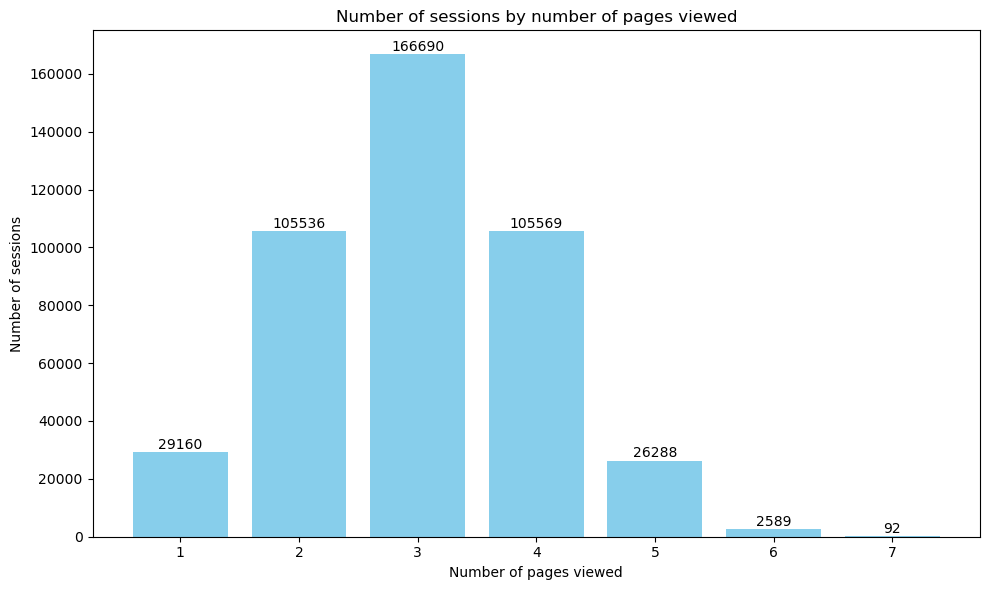

In [5]:
# Group by number of viewed pages and count the number of sessions
page_counts = sessions_history.groupby('page_counter').size().reset_index(name='session_count')

# Build a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(page_counts['page_counter'], page_counts['session_count'], color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, 
             int(yval), ha='center', va='bottom', fontsize=10) 

plt.title('Number of sessions by number of pages viewed')
plt.xlabel('Number of pages viewed')
plt.ylabel('Number of sessions')

plt.tight_layout()
plt.show()

The vast majority of users prefer to view 3 pages. Viewing 2 or 4 pages is also quite common. Also, which may indicate a lack of engagement or interest in the content. A significant decrease in sessions on 5 pages or more indicates a decrease in interest in the application as the user views more content.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

Average share of successful sessions over the entire period: 0.3075


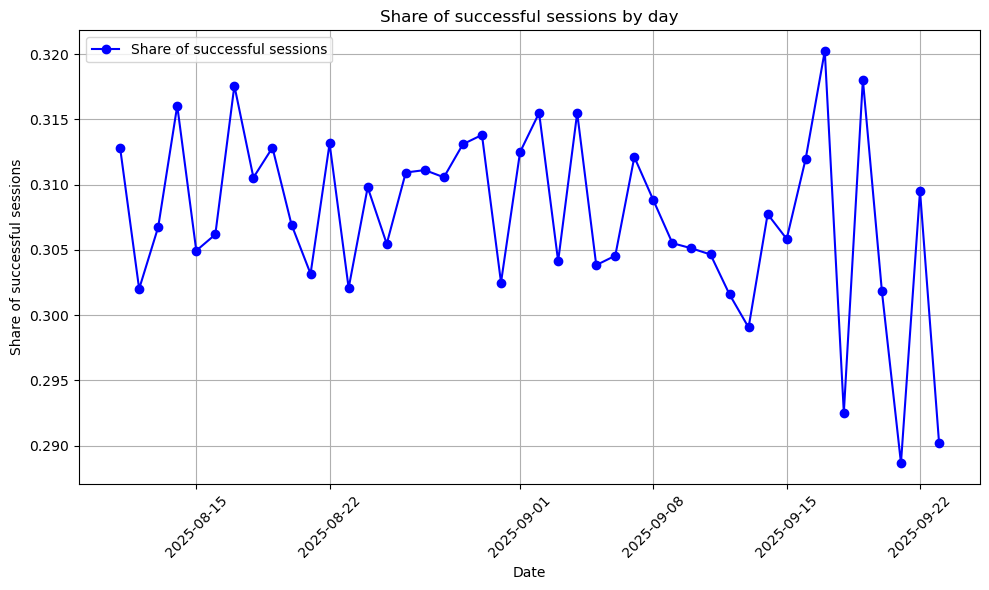

In [6]:
# Add the good_session column
sessions_history['good_session'] = sessions_history['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

# Group by days and calculate the share of successful sessions
daily_sessions = sessions_history.groupby('session_date').agg(
    total_sessions=('session_id', 'nunique'), 
    good_sessions=('good_session', 'sum')  
)

# Group by days and calculate the share of successful sessions
daily_sessions['good_session_share'] = daily_sessions['good_sessions'] / daily_sessions['total_sessions']

# Calculate the average value of the share of successful sessions for all days
average_good_session_share = daily_sessions['good_session_share'].mean()
print(f"Average share of successful sessions over the entire period: {average_good_session_share:.4f}")

# Building a graph
plt.figure(figsize=(10,6))
plt.plot(daily_sessions.index, daily_sessions['good_session_share'], marker='o', color='b', linestyle='-', label='Share of successful sessions')

plt.title('Share of successful sessions by day')
plt.xlabel('Date')
plt.ylabel('Share of successful sessions')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


The percentage of successful sessions during the observation period varies from 29% (on 2025-09-21) to 32% (on 2025-09-17). This means that the percentage of successful sessions fluctuates on different days, but overall remains fairly stable (around 30%).

### 2. Preparing for the test
When planning a test, you need to take several important steps:

- Decide on the target metric.

- Calculate the required sample size.

- Based on the current traffic values, calculate the required duration of the test.

#### 2.1. Sample size calculation
- Significance level — 0.05.

- Type II error probability — 0.2.

- Test power.

- Minimum detectable effect, or MDE, — 3%.

When calculating the sample size, we will use the `solve_power()` method from the `power.NormalIndPower` class of the `statsmodels.stats` module.

In [7]:
# Set parameters
alpha = 0.05 
beta = 0.2 
power = 1 - beta  
mde = 0.03 

# Initialize the NormalIndPower class
power_analysis = NormalIndPower()

# Calculate the sample size
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1
)

print(f"Required sample size for each group is: {int(sample_size)}")

Required sample size for each group is: 17441


#### 2.1. Calculating the duration of an A/B test

In [8]:
# Unique users by day
daily_users = sessions_history.groupby('session_date')['user_id'].nunique()

# Average number of unique users per day
avg_daily_users = daily_users.mean()

# Total test duration considering two groups
test_duration = ceil((sample_size * 2) / avg_daily_users)

print(f"The calculated duration of the A/B test at the current traffic level of {avg_daily_users:.1f} users per day will be {test_duration} days")

The calculated duration of the A/B test at the current traffic level of 9907.4 users per day will be 4 days


### 3. Monitoring A/B testing

#### 3.1. Checking user distribution

The A/B test has been successfully launched, and data for the first three days is already available. At this stage, you need to make sure that everything is going well: users are divided correctly, and the metrics of interest are calculated correctly.

In [9]:
# Loading data
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

sessions_test_part.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [10]:
# Calculate the number of unique users for each group by day
unique_users_per_day = sessions_test_part.groupby(['session_date', 'test_group'])['user_id'].nunique().reset_index()

# Rename columns for convenience after pivot
unique_users_pivot = unique_users_per_day.pivot(index='session_date', columns='test_group', values='user_id').reset_index()
unique_users_pivot.columns.name = None
unique_users_pivot = unique_users_pivot.rename(columns={'A': 'users_A', 'B': 'users_B'})

# Calculate the percentage difference
unique_users_pivot['percentage_diff'] = 100 * abs(unique_users_pivot['users_A'] - unique_users_pivot['users_B']) / unique_users_pivot['users_A']

print(unique_users_pivot)

  session_date  users_A  users_B  percentage_diff
0   2025-10-14     1477     1466         0.744753


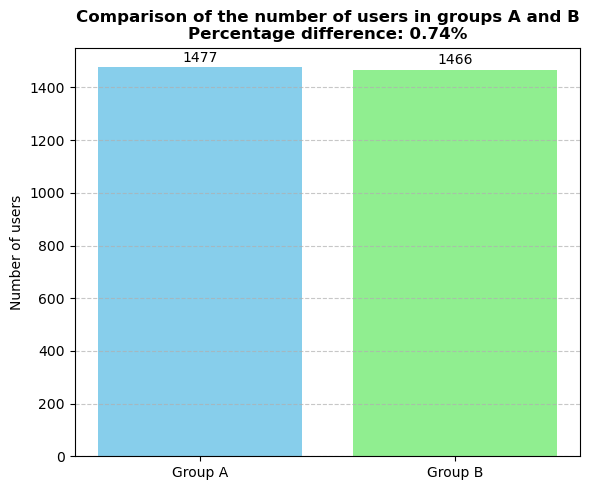

In [12]:
# Values
users_A = unique_users_pivot['users_A'].iloc[0]
users_B = unique_users_pivot['users_B'].iloc[0]
percentage_diff = unique_users_pivot['percentage_diff'].iloc[0]

groups = ['Group A', 'Group B']
values = [users_A, users_B]

# Graph
plt.figure(figsize=(6, 5))
bars = plt.bar(groups, values, color=['skyblue', 'lightgreen'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom', fontsize=10)

plt.title(f'Comparison of the number of users in groups A and B\nPercentage difference: {percentage_diff:.2f}%', fontsize=12, fontweight='bold')

plt.ylabel('Number of users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The difference between the groups is only 0.74%. This means that the distribution of users between A and B is almost perfectly balanced.

#### 3.2. Checking for user intersections
In addition to checking for equality of the number of users in groups, it is useful to ensure that the groups are independent.

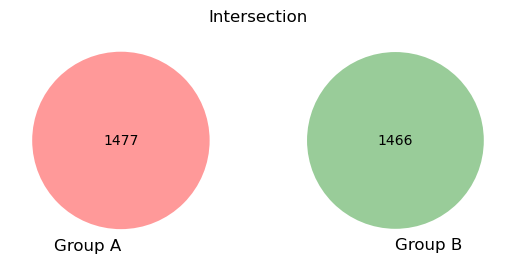

In [13]:
# Get unique users for each group
users_A = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].unique())
users_B = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].unique())

# Building a Venn diagram
venn2([users_A, users_B], set_labels=('Group A', 'Group B'))

plt.title("Intersection")
plt.show()

The number of users that appear in both groups is 0! Thus, the groups are independent.

#### 3.3. Even distribution of users across devices
It is also useful to ensure that users are evenly distributed across all available categorical variables - device types and regions.

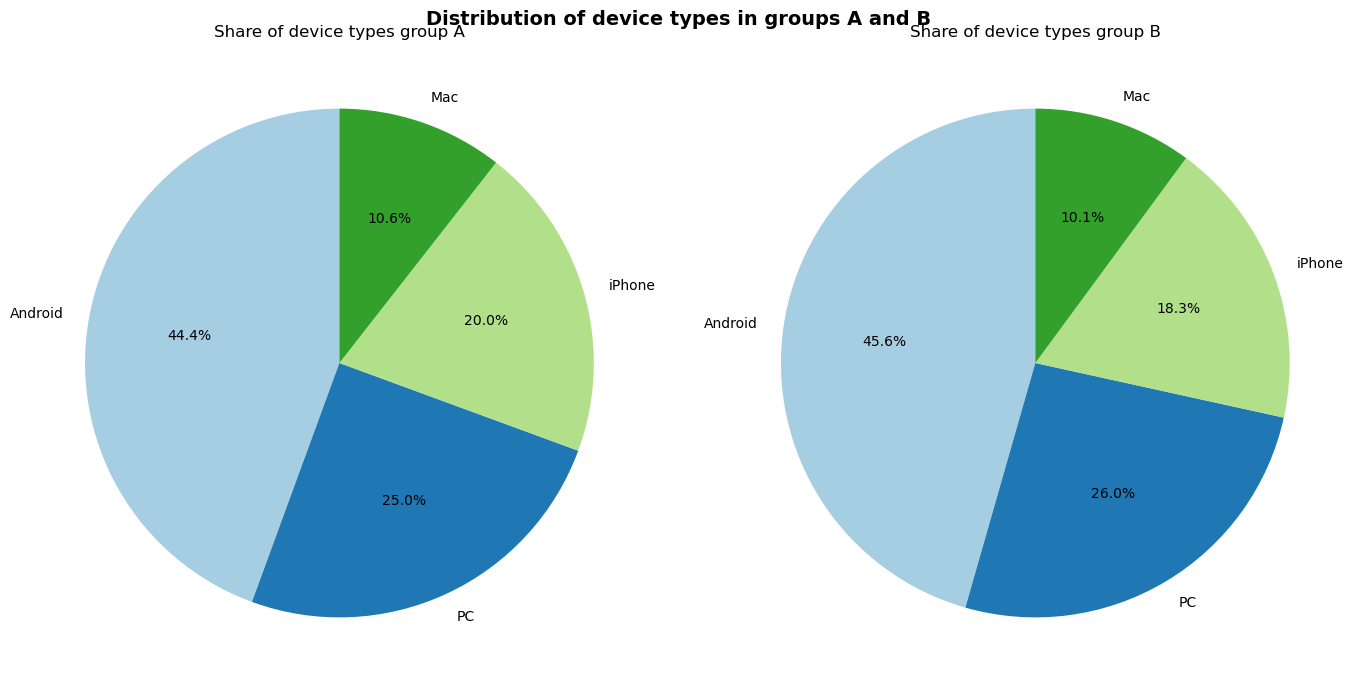

Percentage difference between the shares of device types in groups A and B:
    device   Group A   Group B  Percentage Diff
0  Android  0.444144  0.455662         2.593335
1      Mac  0.105619  0.100955         4.416343
2       PC  0.249831  0.259891         4.026775
3   iPhone  0.200406  0.183492         8.439724


In [14]:
# Select unique user_id - device pairs within each group
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A'][['user_id', 'device']].drop_duplicates()
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B'][['user_id', 'device']].drop_duplicates()

# We calculate the share of unique users by device
devices_A = group_A['device'].value_counts(normalize=True).reset_index()
devices_A.columns = ['device', 'Group A']

devices_B = group_B['device'].value_counts(normalize=True).reset_index()
devices_B.columns = ['device', 'Group B']

# Combine and calculate the percentage difference
devices_comparison = pd.merge(devices_A, devices_B, on='device', how='outer').fillna(0)
devices_comparison['Percentage Diff'] = 100 * abs(devices_comparison['Group A'] - devices_comparison['Group B']) / devices_comparison['Group A']

# Building pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Group A
axes[0].pie(devices_A['Group A'], labels=devices_A['device'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0].set_title('Share of device types group A')

# Group B
axes[1].pie(devices_B['Group B'], labels=devices_B['device'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[1].set_title('Share of device types group B')

plt.suptitle('Distribution of device types in groups A and B', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Таблица
print("Percentage difference between the shares of device types in groups A and B:")
print(devices_comparison)

Based on the provided data, we can draw the following conclusions:

- **Android**: The percentage difference between groups A and B is only **2.59%**.  
  This is a small difference, suggesting that user distribution by device is fairly similar across both groups.

- **PC**: The percentage difference is **4.03%**.  
  While still relatively small, it does indicate slight variation in user distribution between the groups.

- **iPhone**: The percentage difference is **8.43%**,  
  which suggests that the distribution of iPhone users differs somewhat between the groups.  
  This could point to possible differences in user preferences or behavior.

- **Mac**: The percentage difference is **4.42%**, indicating minor discrepancies between groups.

**Overall**, the differences in device distribution are relatively small and are **unlikely to pose significant concerns** for test validity.

#### 3.4. Uniform distribution of users across regions
Now let's make sure that users are evenly distributed across regions.

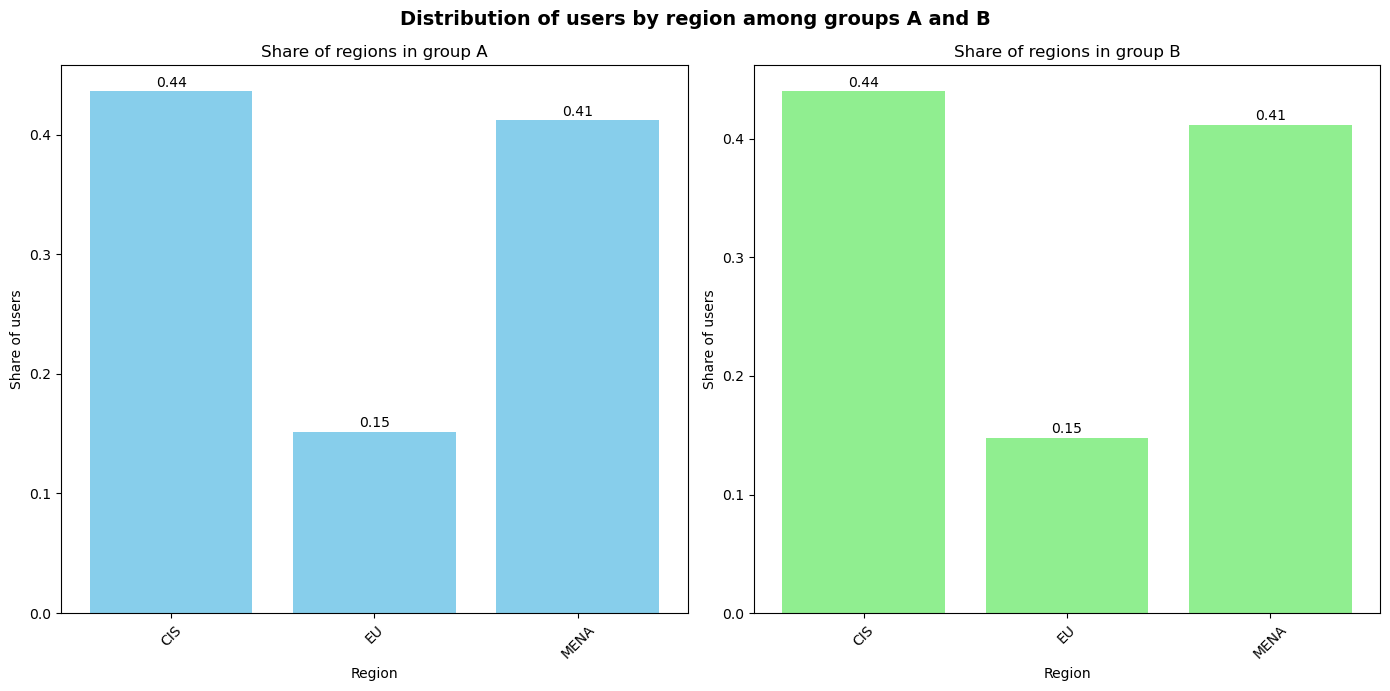

Percentage difference between user shares by region in groups A and B:
  region   Group A   Group B  Percentage Diff
0    CIS  0.436019  0.439973         0.906786
1     EU  0.151659  0.148022         2.398107
2   MENA  0.412322  0.412005         0.076837


In [15]:
# leave only unique pairs user_id + region
unique_users = sessions_test_part[['user_id', 'region', 'test_group']].drop_duplicates()

# We calculate the distribution of regions for group A
regions_A = (unique_users[unique_users['test_group'] == 'A']
             .groupby('region')['user_id']
             .nunique()
             .reset_index()
             .rename(columns={'user_id': 'count_A'}))

regions_A['Group A'] = regions_A['count_A'] / regions_A['count_A'].sum()

# Same for group B
regions_B = (unique_users[unique_users['test_group'] == 'B']
             .groupby('region')['user_id']
             .nunique()
             .reset_index()
             .rename(columns={'user_id': 'count_B'}))

regions_B['Group B'] = regions_B['count_B'] / regions_B['count_B'].sum()

# Merging
regions_comparison = pd.merge(regions_A[['region', 'Group A']],
                               regions_B[['region', 'Group B']],
                               on='region',
                               how='outer').fillna(0)

# Calculate the percentage difference
regions_comparison['Percentage Diff'] = (
    100 * abs(regions_comparison['Group A'] - regions_comparison['Group B']) / regions_comparison['Group A']
)

# Plotting charts with captions
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Graph for Group A
axes[0].bar(regions_comparison['region'], regions_comparison['Group A'], color='skyblue')
axes[0].set_title('Share of regions in group A')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Share of users')
axes[0].tick_params(axis='x', rotation=45)

for i, row in regions_comparison.iterrows():
    axes[0].text(row['region'], row['Group A'] + 0.001, f"{row['Group A']:.2f}", ha='center', va='bottom', fontsize=10)

# Graph for Group B
axes[1].bar(regions_comparison['region'], regions_comparison['Group B'], color='lightgreen')
axes[1].set_title('Share of regions in group B')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Share of users')
axes[1].tick_params(axis='x', rotation=45)

for i, row in regions_comparison.iterrows():
    axes[1].text(row['region'], row['Group B'] + 0.001, f"{row['Group B']:.2f}", ha='center', va='bottom', fontsize=10)

plt.suptitle('Distribution of users by region among groups A and B', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Percentage difference between user shares by region in groups A and B:")
print(regions_comparison)


The percentage differences in user shares by region between groups A and B appear to be minimal:

- **CIS**: The difference in user shares between groups A and B is approximately **0.91%**,  
  indicating a balanced distribution.

- **MENA**: The difference is only **0.07%**, further suggesting no noticeable discrepancy between the samples.

- **EU**: A difference of **2.39%** also indicates that the share of EU users does not differ significantly between the groups.

The absence of significant percentage differences across regions suggests a **balanced regional distribution** of users in both test groups.

#### 3.5. Conclusion after checking the A/B test

**Based on the conducted A/B test analysis, the following conclusions can be drawn:**

1. **Difference in the number of users between groups**  
There was a small difference in user counts between groups A and B.  
On 2025-10-14, group A had 1,477 users, while group B had 1,466 users.  
The percentage difference of **0.74%** is minimal and does not significantly impact the test results.

2. **Sample independence and user overlap**  
It was confirmed that users in groups A and B do not overlap.  
This means the groups are independent, with each user participating in only one group.  
No accidental user crossover between groups occurred.

3. **Balanced distribution across categorical variables (devices and regions)**  
The percentage difference in device types between groups A and B ranges from **2.59% to 8.44%**,  
indicating no major discrepancies in device distribution.  
The percentage difference in user regional shares ranges from **0.07% to 2.40%**,  
also suggesting an even distribution of users by region between the groups.
 
The A/B test design is **valid and reliable** based on all the analyzed indicators.

### 4. Checking the A/B test results

The A/B test is complete and there are results for all days of the experiment. It is necessary to make sure that the test is correct and correctly interpret the results.

#### 4.1. Getting test results and calculating the main metric

In [16]:
# Load the data
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Add the good_session column: 1 if 4 or more pages were viewed, 0 if less
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

sessions_test.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Checking the correctness of test results

We formulate hypotheses before conducting a statistical test:
- H₀ (null hypothesis) — the number of unique daytime sessions `does not differ` between the test and control groups.
- H₁ (alternative hypothesis) — the number of unique daytime sessions `differs` between the test and control groups.

To test the hypotheses put forward, we will conduct a t-test for independent samples.

In [17]:
# Group data by date and test group, counting unique sessions
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

# We divide the data into two groups
group_A_sessions = daily_sessions[daily_sessions['test_group'] == 'A']['session_id']
group_B_sessions = daily_sessions[daily_sessions['test_group'] == 'B']['session_id']

# Perform a t-test for independent samples
t_stat, p_value = stats.ttest_ind(group_A_sessions, group_B_sessions)

# Output p-value
print(f"p-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference is statistically significant. The number of unique daily sessions differs between the test and control groups.")
else:
    print("The difference is not statistically significant. The number of unique daily sessions does not differ between the test and control groups.")

p-value: 0.938219304859116
The difference is not statistically significant. The number of unique daily sessions does not differ between the test and control groups.


#### 4.3. Comparison of the share of successful sessions

We have verified that the number of sessions in both samples did not differ, we can move on to the analysis of the key metric - the share of successful sessions.

In [18]:
# Calculate the share of successful sessions for each group
good_sessions_summary = sessions_test.groupby('test_group')['good_session'].mean().reset_index()

# Transform the data so that the shares for A and B are on the same row
good_sessions_pivot = good_sessions_summary.set_index('test_group').T

# Calculate the percentage difference
good_sessions_pivot['percentage_diff'] = 100 * abs(good_sessions_pivot['A'] - good_sessions_pivot['B'])

print(good_sessions_pivot)

test_group           A        B  percentage_diff
good_session  0.307723  0.31829         1.056657


#### 4.4. How statistically significant is the change in the key metric

The number of successful sessions in the test sample is approximately 1.1% higher than in the control sample, but it would be incorrect to draw conclusions based only on this value. To make a decision, it is necessary to check whether this change is statistically significant.

- H₀ (null hypothesis) - the proportions of successful sessions in groups A and B `do not differ`.
- H₁ (alternative hypothesis) - the proportions of successful sessions in groups A and B `differ`.

To test the hypotheses put forward, we will conduct a Z-test for proportions.

In [19]:
# We count the number of successful sessions and the total number of sessions in each group
success_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
total_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].count()

success_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
total_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].count()

# Form arrays for the test
successes = [success_a, success_b]
samples = [total_a, total_b]

# Performing the Z-test
stat, p_value = proportions_ztest(count=successes, nobs=samples)

# Output the result
print(f"p-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("The difference is statistically significant. The proportions of successful sessions in groups A and B differ.")
else:
    print("The difference is not statistically significant. The proportions of successful sessions in groups A and B do not differ.")

p-value: 0.00031
The difference is statistically significant. The proportions of successful sessions in groups A and B differ.


#### 4.5. Conclusion from the A/B experiment

The experiment was conducted from **2025-10-14 to 2025-11-02**, lasting **19 days**.  
It included two groups of users: **Group A (control)** and **Group B (test)**.  
Group A consisted of **1,477 users**, and Group B included **1,466 users**.  
The groups were well-balanced, mutually exclusive, and independent.

The **key metric** used in the experiment was the **share of successful sessions** — defined as sessions where a user viewed **4 or more pages**.

- Group A (control): **30.77%** successful sessions  
- Group B (test, with new algorithm): **31.83%** successful sessions  
- Absolute difference: **+1.1%**

A **Z-test for proportions** was conducted:  
- **p-value = 0.00031**, which is **below the significance level of 0.05**.  
This result indicates a **statistically significant difference** between the groups, leading to the **rejection of the null hypothesis**.

The new recommendation algorithm has a **positive impact** on user engagement.  
Given the statistically significant increase in successful sessions, **adoption of the new algorithm is justified**.